# Prosjekt 1 - bio

## Contents
* [Introduction](#intro)
* [Model and assumptions](#model)
* [Monomer simulation](#monomer)
* [Cluster formation](#cluster)
* [Polymer simulation](#polymer)
* [Aggregate formation](#aggregate)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

Organelles are tiny structures with one or more specific functions inside of a cell. 
Some organelles have a lipid membrane which separates the interior from the rest of the cell, while others have no membrane. 
Nucleoli are an example of membrane-less organelles. 
They are composed of RNA and proteins, which are both examples of biopolymers. 
That is, molecules containing repeating units. 
These repeating units are known as monomers and are bound together by covalent bonds. 
\
\
The goal of this project is to study the formation of membrane-less organelles such as nucleoli through electrostatic interactions between monomers and polymers. 
We will study both monomer and polymer systems numerically by running a computer simulation. **(burde vi si mer om hvordan?)** We want to find out how the energy develops over time and how long it takes for the system to reach its equilibrium, in addition to how parameters such as temperature and polymer size affects the system. 
\
\
\
**BEGRUNNE BILDER PÅ NETT, FORKLARE HVORDAN LAGD / LAGRA**

In this document we import our images and animations from imgur.com, where we have them stored privately. This is because we want to be able to load the same figures that we have discussed. This also enables us to include images and animations side by side in tables for a better experience. To verify that our code can create figures like the ones we import, simply create the folders “data”, “animations” and “figures”, comment out the necessary code and run the notebook. 


## Model and assumptions <a class="anchor" id="model"></a>

Distance a = 0.53 nm
\
\
When simulating the monomer system, we make **# number of assumptions** the assumption that there are no interactions between any two monomers that are not directly adjacent to each other vertically or horizontally. This is because long range interactions between the monomers are reduced by the solvent screening the electric field. In addition, the Coulomb forces are proportional to $1/r^2$. Therefore, the long range interactions between the monomers can be neglected. This means that when calculating the energy of the system we only need to take in to account neighboring monomers. The energy stored in a bond between two monomers can be calculated by the formula (formell). To find the total energy of the system we need to sum the energy between all neighboring monomers.
\
\
\

\
\








**define r vector**

**define charge**

**Modelling the energy**

$$U_{kl} = \frac{1}{4\pi \varepsilon_0 \varepsilon_r}\frac{Q_k Q_l}{|\vec{r}_k-\vec{r}_l|} 
= w_k w_l \frac{e^2}{4\pi \varepsilon_0 \varepsilon_r a}\frac{ a}{|\vec{r}_k-\vec{r}_l|} 
= w_k w_l \alpha \frac{ a}{|\vec{r}_k-\vec{r}_l|} 
$$

Considering only the energy between the nearest neighbours we have $|\vec{r}_k-\vec{r}_l|=a$. Thus the energy between two monomers is given by:

$$U_{kl} = \begin{cases} w_k w_l α & \text{if } \vec{r}_k \text{ and } \vec{r}_l \text{ are NN,}\\ 
0 & \text{otherwise}.\end{cases}$$

The energy of a system then becomes:

$$U_{system} = \frac{1}{2} \alpha \sum_{\mathrm{grid\, points}} \left( w_{grid\, point} \sum_{NN} w_{NN} \right)$$
The factor $1/2$ in the expression adjusts for double counting.

**Boltzman factor and model +++**


...
\
\
...
\
\

$$
\frac{S_n}{S_i} = \exp \left( {-\frac{E_n-E_i}{k_bT}} \right) 
= \exp \left(-\frac{\alpha}{k_B} \frac{E_n/\alpha-E_i/\alpha}{T} \right)
$$



In [1]:
## Libraries to make fast code
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

## Libraries for maths, plotting and animation
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.animation
import scipy.constants as sc
from IPython.display import HTML, clear_output

## Library for status bar
from tqdm.notebook import tqdm

## Importing and defining the necessary constants
boltzmann = sc.Boltzmann 
epsilon0 = sc.epsilon_0
elemcharge = sc.e
epsilonr = 78
a = 0.53e-9

# This will be our unit of energy
alpha = sc.e **2 / (4 * np.pi * epsilon0*epsilonr*a)

# The constant in the boltzman factor-exponent
k_energy = alpha/boltzmann

In [2]:
## Function that generates N*N grid with 2M monomers
@jit(nopython=True)
def generate_grid_of_monomers(N, M):
    """"
    brief: Returns a NxN grid of integers, 2M of which are the numbers between -M and M
    (excluding 0)
    :param N: int, size of the square grid
    :param M: int, 2M monomers created in total, indexed from -M .. -1, 1 .. M
    :return: (N, N) grid of np.dtype('i2') integers
    """
    grid = np.zeros((N, N), dtype=np.dtype('i2'))
    num = M
    while (num > 0):
        i = np.random.randint(0, N)  # choose random coordinates to place monomer
        j = np.random.randint(0, N)
        if grid[i][j] == 0:  # place monomer if there isn't one there already
            grid[i][j] = -num
            num -= 1  # decrement inside if, ensuring M monomers int total are placed

    num = M
    while (num > 0):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        if grid[i][j] == 0:
            grid[i][j] = num
            num -= 1

    return grid

In [3]:
## Colormaps for visualising our grid
def cMap_green_purple(length):
    color_list = []
    for i in range(0, length):
        color_list.append(np.array([120 + i*100/length, 28, 178]) / 255) # purple
    color_list.append(np.array([159, 220, 233]) / 255)                               # blue
    for i in range(0, length):
        color_list.append(np.array([11, 138 + i*100/length, 0]) / 255)   # green
    return c.ListedColormap(color_list)

def cMap_brown(length):
    color_list = []
    color_list.append(np.array([159, 220, 233]) / 255)                               # blue
    for i in range(0, length):
        color_list.append(np.array([255 - i*200/length, 200 - i*200/length, 150 - i*150/length]) / 255)   # orange
    return c.ListedColormap(color_list)

def visualize_grid(grid, file_title=False, figure_title=False, sign_only=True,
                   cMap_function=cMap_green_purple, title_size=30, fig_size=(10, 10)):
    """
    brief: visualizing grids using a colormesh.
    :param grid: np.array of shape (N, N) grid of integers.
    :param file_title: string=False, if present saves the plot to this filename
    :param figure_title: string=False, if present gives visuzalization a title
    :param sign_only: boolean=True, if False visualization depends on magnitude of integer
    not only sign
    :param cMap_function: func=cMap_green_purple, function for defining colors. Leave as default
    :param title_size: int=30, determines size of title
    :param fig_size: (int, int)=(10, 10), determines size of figure
    :return: None
    """
    # make grid have only -1, 0 and 1. [::-1,] flips the rows
    if sign_only:
        grid = np.sign(grid)
    grid = grid[::-1, ]
    length_color_array = grid.max()
    cMap = cMap_function(length_color_array)

    # plotting as a colormesh
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.pcolormesh(grid, cmap=cMap)
    plt.axis('off')

    # adding titles and saving file
    if figure_title:
        plt.title(figure_title, size=title_size)
    if file_title:
        fig.savefig(f'figures/{file_title}.png')  # save first frame


def animate_grid(grid_list, gif_name, ms_between_frames=10, sign_only=True):
    """
    :param grid_list: [grid1, grid2, ..], list of frames (grids) you want to create gif frome
    :param gif_name: string, name of gif
    :param ms_between_frames: int=10, ms between each frames
    :param sign_only: boolean=True, if visualization should include sign
    :return: None
    """
    # generate colormap. Flip grid.
    if sign_only:
        grid_list = [np.sign(grd) for grd in grid_list]
    grid_list = [grd[::-1, ] for grd in grid_list]
    length_color_array = grid_list[0].max()
    cMap = cMap_green_purple(length_color_array)

    # create figure and remove axis
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.axis('off')

    # prevent duplicate animation figure
    clear_output()

    # for some reason the function doesn't distinguish small numbers... This is a fix
    grid_list = [grd * 1000 for grd in grid_list]

    # create objects for the graphs that will be updated every frame
    cax = ax.pcolormesh(grid_list[0], cmap=cMap)
    fig.savefig(f'animations/{gif_name}_0.png')  # save first frame

    # call this function for every frame in the animation
    def animate(i):
        # replace previous data
        cax.set_array(grid_list[i])
        if i % 1000 == 0:
            print(i)

    # create matplotlib animation object
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(grid_list), repeat=False,
                                             interval=ms_between_frames)
    ani.save(f'animations/{gif_name}.gif')
    fig.savefig(f'animations/{gif_name}_1.png')  # save last frame


def plot_function(x_vals_list, y_vals_list, file_title, errorbars = np.array([0]), title = "",
                  xlabel = "", ylabel = "", fig_size = (9, 5), title_scale_factor = 80,
                  labels = False, loc = "upper right"):
    """
    brief: plots x_vals_list[i] vs y_vals_list[i] and saves to file_title
    :param x_vals_list: list of list, list of x_vals to be plotted
    :param y_vals_list: list of list, list of y_vals to be plotted agains x_vals
    :param file_title: string, filename to save the plote
    :param errorbars: double[], if present plots errorbars on plot
    :param title: string, title of plot
    :param xlabel: string, label of x-axis
    :param ylabel: string, label of y-axis
    :param fig_size: (int, int), figure size
    :param title_scale_factor: int, determines size of title
    :param labels: boolean=False, if true presents plot with legends
    :param loc: string=upper right, determines where legend is
    :return:
    """
    fig = plt.figure(figsize=fig_size)
    if errorbars.any():
        plt.errorbar(x_vals_list[0], y_vals_list[0], yerr = errorbars)
    else:
        fig = plt.figure(figsize=fig_size)
    for i in range(len(y_vals_list)):
        if labels:
            plt.plot(x_vals_list[i], y_vals_list[i], label = labels[i])
        else:
            plt.plot(x_vals_list[i], y_vals_list[i])
    title_size = int(title_scale_factor * fig_size[0] / len(title))
    plt.title(title, size = title_size)
    label_size = int(2/3 * title_size)
    plt.xlabel(xlabel, size = label_size)
    plt.ylabel(ylabel, size = label_size)
    if labels:
        plt.legend(loc = loc)
    fig.savefig(f'figures/{file_title}.png') # save first frame

Now we will implement energy function ...

In [4]:
@jit(nopython=True)
def total_energy(grid):
    """
    brief: calculates the total interaction energy of a gried of monomers
    :param grid: (int, int) grid of integers, with monomers placed as nonzero integers
    :return: int, the total energy in units of alpha
    """
    # create grid of charge signs
    sign_grid = np.sign(grid)
    E = sign_grid[0] * 0
    # energy between each square and top, bottom, left and right neighbour
    for row in sign_grid:
        E += row * np.roll(row, -1)
        E += row * np.roll(row, 1)
    for row in sign_grid.T:
        E += row * np.roll(row, -1)
        E += row * np.roll(row, 1)

    return 1 / 2 * np.sum(E)  # account for double count

In [5]:
# # Uncomment to create grids with energies
# N, M = [5, 10, 15], [6, 15, 30]
# grid_list = []
# for i in range(3):
#     n, m = N[i], M[i]
#     grid = generate_grid_of_monomers(n, m)
#     grid_list.append(grid)
#     e = total_energy(grid)
#     visualize_grid(grid, file_title = f"grid_and_energy_monomer_figure_{i+1}", 
#                    figure_title = f"Grid with N={n}, M={m} and E={e} α", title_size = 28)

Show the figure bla bla bla
Energy can be verified by adding up -1 * # different colored bonds + # same colored bonds


||||
:-------------------------:|:-------------------------:|:-------------------------:
![](https://i.imgur.com/Znk8wO2.png)  |  ![](https://i.imgur.com/p5r9AS8.png)  |  ![](https://i.imgur.com/yoCvLRs.png)  |



## Monomer simulation <a class="anchor" id="monomer"></a>

In [6]:
@jit(nopython=True)
def nearest_neighbours(i, j, N):
    """
    brief: takes in x, y coordinates and grid size. Returns the x, y coordinates
    of the 4 neaerest neighbors
    :param i: int, y coordinate of monomer
    :param j: int, x coordinate of monomer
    :param N: int, size of the grid i, j is placed
    :return: list of points
    """
    top = [i, (j-1+N)%N]
    right = [(i+1)%N, j]
    bottom = [i, (j +1)%N]
    left = [(i-1 + N)%N, j]
    return [top, right, bottom, left]


@jit(nopython=True)
def swap(grid, coord1, coord2):
    """
    brief: changes the input grid. takes in a grid and two (x1, y1), (x2, y2) points.
    swaps grid[y1][x1] and grid[y2][x2]
    :param grid: (int, int), grid of monomers
    :param coord1: list or tuple (int, int), (x, y) coordinates of element to be swapped
    :param coord2: list or tuple (int, int), (x, y) coordinates of element to be swapped
    :return: None
    """
    x1, y1 = coord1
    x2, y2 = coord2

    temp_val = grid[x1][y1]
    grid[x1][y1] = grid[x2][y2]
    grid[x2][y2] = temp_val

@jit(nopython=True)
def move_monomer(coords, direction, grid):
    """
    brief: finds the neighbor of coords in direction, returns coords of neighbor
    and if the move is legal (if the move is to an empty spot)
    :param coords: (int, int), coordinates of monomer to be moved
    :param direction: int 0-3, represents directions
    :param grid: (int, int) grid,
    :return: (int, int), boolean,  coordinates of neighbor and if the move is legal
    """
    neighbours = nearest_neighbours(i=coords[0], j=coords[1], N=grid.shape[0])
    move = neighbours[direction]
    move_val = grid[move[0]][move[1]]

    return move, move_val==0

@jit(nopython=True)
def monte_carlo_sim(Ns, N, M, T, grid, fill_grid_list = False):
    """
    brief: monte carlo simulation of monomers
    :param Ns: int, the number of MC steps
    :param N: int, grid size
    :param M: int, the number of monomers
    :param T: double, temperature of the simulation
    :param grid: (N, N) grid of ints
    :param fill_grid_list: boolean=False, if True fills a list of every grid
    in the simulation
    :return:
    """
    # list of the energies
    e = np.zeros(Ns, dtype="float64")
    E = total_energy(grid)
    e[0] = E

    #generates a np list of Ns x (N, N) matrices, to store every grid in the sim
    grids = np.zeros((Ns, N, N), dtype=np.dtype('i2'))

    #simulation loop
    for i in range(Ns):
        #random number between 1 and M, multiplied by either 1 or -1 to get
        #random numher between [-M, -1] or [1, M]
        monomer = np.random.randint(1, M+1)
        sign = int(2*(np.random.randint(2) - 0.5))
        monomer_coordinates = np.argwhere(grid==monomer*sign)[0]

        direction = np.random.randint(0, 4) # 0: up, 1: right, 2: down, 3: left
        move, legal_move = move_monomer(monomer_coordinates, direction, grid)


        if legal_move:
            swap(grid, move, monomer_coordinates)
            Enew = total_energy(grid)

            #Metropolis scheme. E = Enew if energy goes down
            #some chance of E = Enew if energy is greater
            if Enew < E:
                E = Enew
            elif np.random.random() < np.exp(-k_energy*(Enew-E)/T):
                E = Enew
            else:
                swap(grid, move, monomer_coordinates) # swapping back if the grid shouldnt be updated
        if fill_grid_list:
            grids[i] = grid
        e[i] = E

    return e, grids




We can demonstrate the algorithm using our animation function

When it slows down it is checking unaccepted moves

|Grid before alogithm | Grid during algorithm | Grid after algorithm |
:-------------------------:|:-------------------------:|:-------------------------:
![](https://i.imgur.com/qT0TknT.png)  |  ![](https://i.imgur.com/xKL2luq.gif)  |  ![](https://i.imgur.com/r9aEm6M.png)  |
![](https://i.imgur.com/6CCbxwE.png)  |  ![](https://i.imgur.com/JufJe8h.gif)  |  ![](https://i.imgur.com/6o7E5Fm.png)  |



In [7]:
# # Uncomment to save monomer simulation data
# Ns = 50000
# N = 15
# M = 25
# T = 200
# grid1 = generate_grid_of_monomers(N, M)
# grid2 = grid1.copy()
# e, grids = monte_carlo_sim(Ns, N, M, T, grid1, fill_grid_list = True)
# np.savez('data/monomer_sim_T200.npz', e=e, grids=grids)

# T = 500
# e, grids = monte_carlo_sim(Ns, N, M, T, grid2, fill_grid_list = True)
# np.savez('data/monomer_sim_T500.npz', e=e, grids=grids)

# # Uncomment to create energy plot
# data200 = np.load('data/monomer_sim_T200.npz')
# data500 = np.load('data/monomer_sim_T500.npz')

# plot_function([np.arange(1, 50001, 1), np.arange(1, 50001, 1)], [data200['e'], data500['e']], 
#               "EnergyDev50000", title = "Energy development", title_scale_factor=55,
#               xlabel = "iterations", ylabel = r"E / $\alpha$", fig_size = (8, 4),
#               labels = ["T = 200 K", "T = 500 K"], loc = "lower left")

# # Uncomment to create animations
# data200 = np.load('data/monomer_sim_T200.npz')
# data500 = np.load('data/monomer_sim_T500.npz')

# grids200 = data200['grids']
# grids500 = data500['grids']

# animate_grid(grids200[::10], 'monomer_sim_T200', ms_between_frames = 10, sign_only = True)
# animate_grid(grids500[::10], 'monomer_sim_T500', ms_between_frames = 10, sign_only = True)

\
\
**MÅ FINNE EN MÅTE Å "DETERMINE VISUALLY NUMBER OF STEPS!!!"**
\
\
![](https://i.imgur.com/hNvfgri.png)
\
\

From the plot we can se that it takes approximately **x_1** MC steps for the system with temperature **T_1** to reach its equilibrium, while the system with temperature **T_2** takes **x_2** steps to reach equilibrium. From our implementation of the MC algorithm we can se that a higher temperature increases the probability of a monomer making a move which increases the total energy of the system. This explains why the energy of system 2 varies more after reaching its equilibrium. **(Mer om hvorfor de er forskjellige, og hvorfor det stemmer med fysikken.)**\
\
\
\
\
**ENERGY MINIMA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**
\
\
\
\
\
\

## Cluster formation <a class="anchor" id="cluster"></a>

In [8]:
@jit(nopython=True)
def add_to_cluster(i, j, num, grid, cluster_grid):
    """
    brief: works recursively with get_cluster_grid
    :param i: int, y coordinate
    :param j: int, x coordinate
    :param num: int, id of cluster
    :param grid: grid to check
    :param cluster_grid: grid to change
    :return: None
    """
    if cluster_grid[i][j] == 0 and grid[i][j] != 0:
        cluster_grid[i][j] = num
        neighbours = nearest_neighbours(i, j, len(grid))

        for neighbor in neighbours:
            add_to_cluster(neighbor[0], neighbor[1], num, grid, cluster_grid)


@jit(nopython=True)
def get_cluster_grid(grid):
    """
    brief: inputs a grid and, assigns each cluster a number between 1 and Nc (number of clusters)
    :param grid: grid of (int, int)
    :return: cluster grid with clusters represented by int id and number of clusters
    """
    cluster_grid = np.zeros((len(grid), len(grid)), dtype=np.dtype('i2'))
    num = 1

    for i in range(len(grid)):
        for j in range(len(grid)):
            if cluster_grid[i][j] == 0 and grid[i][j] != 0:
                add_to_cluster(i, j, num, grid, cluster_grid)
                num += 1

    return cluster_grid, num - 1

In [9]:
# data200 = np.load('data/monomer_sim_T200.npz')
# final_grid200 = data200['grids'][-1]
# visualize_grid(final_grid200, file_title = "FinalGridT200")

# cluster_grid200 = get_cluster_grid(final_grid200)[0]
# visualize_grid(cluster_grid200, file_title = "Cluster_FinalGridT200", cMap_function = cMap_brown, sign_only = False)

|Monomer grid | Cluster grid |
:-------------------------:|:-------------------------:|
![](https://i.imgur.com/c3GqXiU.png)  |  ![](https://i.imgur.com/vKTDu9y.png)  |



**Discuss if n gives reliable results**

Forklare 2M/get_cluster[1]...

In [10]:
@jit(nopython=True)
def average_d_sim(N, M, temps, s=1 / 200, C=10000, t_max=100000, n=100, t_r=1000):
    """
    brief: generates a grid of (N, N) ints and does t_equil MC simulations.
    after that, the average cluster size d is measured n times every t_r simulation
    :param N: int, grid size
    :param M: int, number of polymers
    :param temps: list of double, different temperatures to perform simulation
    :param s: double, determines t_equil
    :param C: double, determines t_equil
    :param t_max: double, determines t_equil
    :param n: int, the number of measurements
    :param t_r: int, the number of MC simulations between each measurement
    :return: (float, float), list of avg distances and corresponding standard deviations
    """

    #creates lists to be filled during the sim
    avg_dist = np.zeros(len(temps), dtype="float64")
    std_dev = np.zeros(len(temps), dtype="float64")

    #simulation loop. Loops through all temperatures
    for j in range(len(temps)):
        print(f"Working on temperature {j + 1}/{len(temps)}")
        T = temps[j]
        grid = generate_grid_of_monomers(N, M)

        #performs t_equil sims before starting measurements to reach equillibrium
        t_equil = t_max * np.exp(-s * (T - temps[0])) + C
        Ns = int(t_equil)
        monte_carlo_sim(Ns, N, M, T, grid)

        #measurement loop. Does t_r MC sims for every n and stores the average d
        d_avg = np.zeros(n, dtype="float64")
        for i in range(n):
            monte_carlo_sim(t_r, N, M, T, grid)
            d_avg[i] = 2 * M / get_cluster_grid(grid)[1] #

        #calculations of mean and std
        avg_dist[j] = sum(d_avg) / n
        std_dev[j] = np.std(d_avg)
    return avg_dist, std_dev


In [11]:
# # Uncomment to do 2 simulations of average d
# N=15
# M=25
# temperatures = np.linspace(100, 1000, 10)
# for i in range(2):
#     d, std = average_d_sim(N, M, temperatures, n=100)
#     plot_function([temperatures], [d], f"d_and_temp_{i}", errorbars = std, 
#                   title = r"$\overline{d}$ as function of temperature, run " + f'{i+1}', 
#                   xlabel = r"$T$ [K]", ylabel = r"$\overline{d}$", fig_size = (12, 5))
#     plt.show()

\


\\

\
\
\
\
\

<td style="width: 50%"> <img src="https://i.imgur.com/8JTu2jC.png" alt="Drawing" /> </td>

<td style="width: 50%"> <img src="https://i.imgur.com/KeYOHWx.png" alt="Drawing" /> </td>



**NEED ONE MORE, compare, discrepancy at low T +++**


As we can see from the plot, <d> is larger at lower temperatures. This is because when the temperature is lower, the probability of making a move that increases the energy of the system is lower. A move that would increase the energy of the system would be a monomer disconnecting from a cluster. At higher temperatures the probability of making such a move is higher, therefore explaining the discrepancy between <d> at the different temperatures. (var noen av resultatene overraskende ?). At lower temperatures the probability of monomers breaking off from a cluster and forming a new cluster is smaller, because such a move would temporarily increase the energy of the system. This is more likely to happen at higher temperatures where the probability of increasing the energy is larger. Therefore, the results are more dependent on the initial conditions, which are randomized, when the temperature is lower. This can explain why the discrepancy between the simulations is larger at lower temperatures. 

**DISCUSS CHOICE OF N, surprising results, **

## Polymer simulation <a class="anchor" id="polymer"></a>

fra nå av er a = $8.3$ nm\
\
\
\
When studying the polymer system, we will again make the assumption that there are no interactions between monomers not directly adjacent to each other. In addition, all interactions between monomers belonging to the same polymer will be set to zero, as it will make the simulation less computationally demanding. We will also assume that polymers cannot be broken, meaning that there will always be a path between any two monomers belonging to the same polymer, and this path contains only monomers of that same polymer. 


In [12]:
a = 8.3e-9
alpha = sc.e **2 / (4 * np.pi * epsilon0*epsilonr*a)
k_energy = alpha/boltzmann

@jit(nopython=True)
def build_polymer(grid, N, L, num):
    """
    brief: never use!, use only inside generate_grid_of_polymers
    :param grid:
    :param N:
    :param L:
    :param num:
    :return:
    """
    num2 = L - 1
    max_iter = N * N * N
    while (num2 > 0):
        i2 = np.random.randint(0, N)
        j2 = np.random.randint(0, N)
        neighbours = nearest_neighbours(i2, j2, N)
        neighbourNum = [grid[neigh[0]][neigh[1]] for neigh in neighbours]
        if grid[i2][j2] == 0 and num in neighbourNum:
            grid[i2][j2] = num
            num2 -= 1
        else:
            max_iter -= 1
            if (max_iter == 0):
                return False
    return True


@jit(nopython=True)
def generate_grid_of_polymers(N, M, L):
    """
    brief: similar to generate_grid_of_monomers, but creates 2M polymers of length L
    :param N: int, grid size
    :param M: int, number of polymers
    :param L: int, length of polymers
    :return: (int, int), grid of polymers
    """
    #creates grid of zeros, to be filled with polymers
    grid = np.zeros((N, N), dtype=np.dtype('i2'))

    #fill the polymers with id [-M, -1]
    num = M
    while (num > 0):
        i = np.random.randint(0, N)  # choose random coordinates to place first monomer
        j = np.random.randint(0, N)
        if grid[i][j] == 0:  # place monomer if there isn't one there already
            grid[i][j] = -num
            if build_polymer(grid, N, L, -num):
                num -= 1  # decrement inside if, ensuring M polymers in total are placed
            else:
                for monomer in np.argwhere(grid == -num):
                    i, j = monomer
                    grid[i][j] = 0

    # fill the polymers with id [1, M]
    num = M
    while (num > 0):
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        if grid[i][j] == 0:
            grid[i][j] = num
            if build_polymer(grid, N, L, num):
                num -= 1
            else:
                for monomer in np.argwhere(grid == num):
                    i, j = monomer
                    grid[i][j] = 0

    return grid

In [13]:
@jit(nopython=True)
def polymer_total_energy(grid):
    """
    brief: calculates the total energy of a polymer system, see notebook
    for more detail
    :param grid: grid of (int, int)
    :return: int, total energy of system in units of alpha
    """
    N = grid.shape[0]
    E = 0
    for i in range(N):
        for j in range(N):

            neighbours = nearest_neighbours(i, j, N)
            current_cluster_val = grid[i][j]
            for neighbor in neighbours:
                xcoord, ycoord = neighbor
                if grid[xcoord][ycoord] != current_cluster_val:
                    E += np.sign(current_cluster_val * grid[xcoord][ycoord])
    return E / 2

In [14]:
# N, M, L = [10, 15, 25], [2, 4, 6], [10, 20, 30]
# for i in range(3):
#     n, m, l = N[i], M[i], L[i]
#     grid = generate_grid_of_polymers(n, m, l)
#     e = polymer_total_energy(grid)
#     visualize_grid(grid, file_title = f"grid_and_energy_polymer_figure_{i+1}", 
#                    figure_title = f"Grid with N={n}, M={m}, L={l} and E={e} α", 
#                    title_size = 25, sign_only = False)

||||
:-------------------------:|:-------------------------:|:-------------------------:
![](https://i.imgur.com/5uTo7Ev.png)  |  ![](https://i.imgur.com/dNoPpUo.png)  |  ![](https://i.imgur.com/g7IdEir.png)  |

In [15]:
@jit(nopython=True)
def rigid_move_polymer(direction, num, grid):
    """
    brief: Changes grid. implementation of the rigid move described in notebook.
    moves a polymer one block in random direction
    :param direction: int 0-3, represents direction
    :param num: int, id of grid
    :param grid: grid of (int, int)
    :return: boolean, true if move successful, else false.
    """
    size = grid.shape[0]
    polymer = np.argwhere(grid == num)
    for monomer in polymer:
        neighbor = nearest_neighbours(monomer[0], monomer[1], size)[direction]
        i = neighbor[0]
        j = neighbor[1]

        if (grid[i][j] != 0 and grid[i][j] != num):
            return False

    for monomer in polymer:
        neighbor = nearest_neighbours(monomer[0], monomer[1], size)[direction]
        i = neighbor[0]
        j = neighbor[1]

        grid[i][j] += num
        grid[monomer[0]][monomer[1]] -= num

    return True

In [16]:
@jit(nopython=True)
def monte_carlo_sim_polymer(Ns, N, M, T, grid, move_function, fill_grid_list = False):
    """
    brief: implementation of the Metropolis Monte Carlo simulation with polymers.

    :param Ns: int, number of simulations
    :param N: int, size of grid
    :param M: int, number of polymers
    :param T: double, temperature
    :param grid: grid of (int, int)
    :param move_function: functype, which function (rigid_move or flex_move) to use
    :param fill_grid_list: boolean=False, if True returns list of every grid
    :return: (double[], int[][]), energies and grids if fill_grid_list
    """
    # list of the energies
    e = np.zeros(Ns, dtype="float64") #list of the energies
    E = polymer_total_energy(grid)
    e[0] = E

    #list of every grid
    grids = np.zeros((Ns, N, N), dtype=np.dtype('i2'))

    #simulation loop
    for i in range(Ns):
        #chooses random polymer id, numbers in [-M, -1] or [1, M]
        polymer = int(2*(np.random.randint(2) - 0.5)) * np.random.randint(1, M+1) # sign * num
        direction = np.random.randint(0, 4) # 0: up, 1: right, 2: down, 3: left
        grid0 = grid.copy()

        #makes the move, move_function returns true if move was made
        legal_move = move_function(direction, polymer, grid)
        if legal_move:
            Enew = polymer_total_energy(grid)
            if Enew < E:
                E = Enew
            elif np.random.random() < np.exp(-k_energy*(Enew-E)/T):
                E = Enew
            else:
                grid = grid0
        e[i] = E
        if fill_grid_list:
            grids[i] = grid
    return e, grids


In [17]:
# # Uncomment this code to save data from rigid simulation
# L = 12
# M = 5
# T = 200
# N = 20
# Ns = 30000
# grid_rigid = generate_grid_of_polymers(N, M, L)
# grid_flex  = grid_rigid.copy() # We will do the same simulation with medium flex move
# e, grids = monte_carlo_sim_polymer(Ns, N, M, T, grid_rigid, rigid_move_polymer, fill_grid_list=True)
# np.savez('data/monte_carlo_rigid.npz', e=e, grids=grids)

# # Uncomment this code to create animation and save images of grid0 and the final grid
# data_rigid  = np.load('data/monte_carlo_rigid.npz')
# grids_rigid = data_rigid['grids']
# animate_grid(grids_rigid[::10], 'monte_carlo_rigid', sign_only = False)

# # Uncomment this code to create a plot of the energy
# data_rigid  = np.load('data/monte_carlo_rigid.npz')
# e_rigid = data_rigid['e']
# plot_function([np.arange(1, Ns+1, 1)], [e_rigid], 
#               "monte_carlo_rigid_energy", title = "Energy development with rigid move", 
#               title_scale_factor=55, xlabel = "iterations", ylabel = r"E / $\alpha$", 
#               fig_size = (8, 4))


<table><tr>
<td> <img src="https://i.imgur.com/8VLGC7k.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="https://i.imgur.com/SqbXbuQ.gif" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="https://i.imgur.com/dwlKxKD.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>



In [18]:
@jit(nopython=True)
def contains(polymer, monomer0):
    """
    brief: checks if monomer0 is in polymer list
    :param polymer: list of monomers
    :param monomer0: monomer
    :return: boolean
    """
    for monomer in polymer:
        if monomer[0] == monomer0[0] and monomer[1] == monomer0[1]:
            return True
    return False

@jit(nopython=True)
def depth_first_search(monomer, num, grid, visited, index):
    """
    brief: implementation of the dfs algorithm. Starts with a monomer
    and checks how many monomers we reach. If we cant reach all, the
    polymer is broken.
    :param monomer: initial monomer
    :param num: int, id of polymer
    :param grid: grid of (int, int)
    :param visited: list of every monomer visited
    :param index: last index where a monomer was inserted into visited
    :return: None
    """
    if contains(visited, monomer) or index == visited.shape[0]:
        return
    visited[index[0]] = monomer
    index += 1
    for neighbour in nearest_neighbours(monomer[0], monomer[1], grid.shape[0]):
        if grid[neighbour[0]][neighbour[1]] == num:
            depth_first_search(neighbour, num, grid, visited, index)
    return


@jit(nopython=True)
def polymer_is_broken(polymer, num, grid, L):
    """
    brief: uses depth_first_search to increment index. If index reaches L,
    the polymer is not broken.
    :param polymer: list of monomers
    :param num: int, id of polymer
    :param grid: grid of (int, int)
    :param L: int, length of polymers
    :return: boolean, True if broken, False if not
    """
    visited = -np.ones(polymer.shape, dtype=np.dtype('i2'))
    index = np.zeros(1, dtype=np.dtype('i2'))
    depth_first_search(polymer[0], num, grid, visited, index)
    return index[0] != L


@jit(nopython=True)
def medium_flex_move(direction, num, grid):
    """
    brief: implementation of the medium flex move mentioned in notebook.
    :param direction: int 0-3, represents random directions
    :param num: int, id of polymer
    :param grid: grid of (int, int)
    :return: boolean, True if moved else False
    """
    #getting system config from grid and polymer
    N = grid.shape[0]
    polymer = np.argwhere(grid == num)
    L = polymer.shape[0]

    #list of neighbors of polymer[i], to be filled
    neighbours = np.zeros(polymer.shape, dtype=np.dtype('i2'))

    #list of rows/cols which is illegal. Row to move determines if row or col
    illegals = np.zeros(N)
    row_to_move = direction % 2

    #loops through every monomer, finds neighbor in direction
    # and determines if that row/col is legal to move
    for i in range(L):
        monomer = polymer[i]
        neighbours[i] = nearest_neighbours(monomer[0], monomer[1], N)[direction]
        x, y = neighbours[i]
        if grid[x][y] != 0 and grid[x][y] != num:
            illegals[neighbours[i][row_to_move]] = 1

    #loops through every monomer, moves monomer to neighbor if row/col is legal
    for monomer, neighbour in zip(polymer, neighbours):
        index = monomer[row_to_move]
        if illegals[index] == 0:
            i, j = monomer
            x, y = neighbour
            grid[i][j] -= num
            grid[x][y] += num

    #checks if polymer is broken, undoes the move if it is
    new_polymer = np.argwhere(grid == num)
    if polymer_is_broken(new_polymer, num, grid, L):
        for monomer in new_polymer:
            grid[monomer[0]][monomer[1]] = 0
        for monomer in polymer:
            grid[monomer[0]][monomer[1]] = num
        return False

    return True

<Figure size 576x288 with 0 Axes>

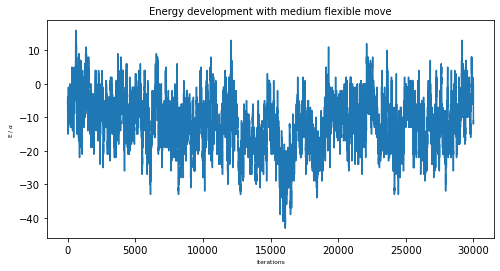

In [19]:
# # Uncomment these lines to run this cell without doing rigid move simulation first
# L = 12
# M = 5
# T = 200
# N = 20
Ns = 30000
# grid_flex = generate_grid_of_polymers(N, M, L) # We use the same grid as flexible

# # Uncomment these lines to to flexible simulation
# e, grids = monte_carlo_sim_polymer(Ns, N, M, T, grid_flex, medium_flex_move, fill_grid_list=True)
# np.savez('data/monte_carlo_flex.npz', e=e, grids=grids)

# # Create animation
# data_flex  = np.load('data/monte_carlo_flex.npz')
# grids_flex = data_flex['grids']
# animate_grid(grids_flex[::10], 'monte_carlo_flex', sign_only = False)

# # Create energy plot
data_flex   = np.load('data/monte_carlo_flex.npz')
e_flex  = data_flex['e']
plot_function([np.arange(1, Ns+1, 1)], [e_flex], 
              "monte_carlo_flex_energy", title = "Energy development with medium flexible move", 
              title_scale_factor=55, xlabel = "iterations", ylabel = r"E / $\alpha$", 
              fig_size = (8, 4))

Show grid and animations


<table><tr>
<td> <img src="https://i.imgur.com/PuooVyA.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="https://i.imgur.com/UpKQj86.gif" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="https://i.imgur.com/8ovz0om.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>



<img src="https://i.imgur.com/MNaeyM0.png" alt="Drawing" style="width: 500px;"/> 
    
<img src="https://i.imgur.com/jwVaWUt.png" alt="Drawing" style="width: 500px;"/>

## Aggregate formation <a class="anchor" id="aggregate"></a>

JUSTIFY tequil and n
\
\
\


JUSTIFY t equil

MÅ VÆRE STØRRE

FORKLARE dL_avg

In [20]:
def average_dL_sim(N, M, T, lengths, s=1 / 200, C=10000, t_max=100000, n=100, t_r=1000, move_function=medium_flex_move):
    """
    brief: performs the d/l simulation
    :param N: int, size of grid
    :param M: int, number of polymers
    :param T: double, the temperature to perform calculation
    :param lengths: double[], list of L-values to perform the simulation
    :param s: to determine t_equil
    :param C: to determine t_equil
    :param t_max: to determine t_equil
    :param n: int, the number of measurements
    :param t_r: int, the number of simulations between each measaurement
    :param move_function: functype, determines which move function (rigid or flex) to be used
    :return: (double[], double[]), list of avg d/l and corresponding standard deviations
    """
    #lists of avg d/l and std, to be filled
    avg_distL = np.zeros(len(lengths), dtype="float64")
    std_dev = np.zeros(len(lengths), dtype="float64")

    #simulation loop
    for j in tqdm(range(len(lengths))):
        #parameters of current sim
        L = lengths[j]
        grid = generate_grid_of_polymers(N, M, L)

        #performs t_equil sims before starting measurements
        t_equil = t_max * np.exp(-s * (T - 100)) + C  # REF TEMP 100 CHEDK LATER
        Ns = int(t_equil)
        monte_carlo_sim_polymer(Ns, N, M, T, grid, move_function)

        #list of dL vals, to be filled and averaged
        dL_avg = np.zeros(n, dtype="float64")
        for i in range(n):
            monte_carlo_sim_polymer(t_r, N, M, T, grid, move_function)
            dL_avg[i] = 2 * M / (get_cluster_grid(grid)[1])  # FORKLARE (2ML)/(#cluster*L)

        #final calculations of mean and standard deviation
        avg_distL[j] = sum(dL_avg) / n
        std_dev[j] = np.std(dL_avg)
    return avg_distL, std_dev

In [21]:
# # Uncomment to save data from average d/L simulation
# lengths = np.linspace(3, 39, 13).astype(int)
# T = 300
# N = 30
M = 5
# avg_distL, std_dev = average_dL_sim(N, M, T, lengths)
# np.savez('data/average_dL_sim.npz', avg_distL=avg_distL, std_dev=std_dev, lengths=lengths)

# # Create plot of average d/L
# data = np.load('data/average_dL_sim.npz')
# avg_distL = data['avg_distL']
# std_dev   = data['std_dev']
# lengths   = data['lengths']
# plot_function([lengths], [avg_distL], 'Test_of_average_dL', errorbars = std_dev, title = "Test of average d/L", 
#                   xlabel = "L", ylabel = "$\overline{d/L}$", fig_size = (7, 4), title_scale_factor = 60)
# plt.show()

# Create plot of average number of polymers in each aggregate
# plot_function([lengths], [2*M/avg_distL], 'Number_of_aggregates', title = "Number of aggregates", 
#                   xlabel = "L", ylabel = "$\overline{N_C}$", fig_size = (7, 4), title_scale_factor = 60)

<img src="https://i.imgur.com/HOM5bKC.png" alt="Drawing" style="width: 500px;"/> 



<img src="https://i.imgur.com/vFhUKM8.png" alt="Drawing" style="width: 500px;"/>


*Ola sin gode forklaring ...*

One interesting aspect of the $\overline{d/L}$ figure REF1 is the clear correlation between the standard deviation error bars and L. Larger L-values, or more specifically larger $\langle \frac{d}{l} \rangle$, seem to result in a larger standard deviation. The exact relationship will, of course, vary due to the probabilistic nature of simulation. However, the correlation is evident. 

A natural explanation can be obtained from the following calculation: 

$$\langle \frac{d}{l} \rangle = \langle \frac{2 L M}{N_c} / L \rangle = \langle \frac{2 M }{N_c}\rangle = \frac{2 M }{\langle N_c \rangle} \rightarrow \langle N_c \rangle = \frac{2M}{\langle \frac{d}{l} \rangle}$$ 
where $\langle N_c \rangle$ is the average number of clusters the polymers have formed. The plot of $\langle N_c \rangle$ can be seen in fig REF2. For larger L, the tendency seen in REF1 is to create larger clusters, which obviously result in fewer clusters overall, REF2. If a system has, say, one or two clusters, the breaking of any of these would result in a totally different $\langle \frac{d}{l} \rangle$ due to the large variations of $\langle d \rangle$. Consider an example: let the total amount of monomers $N = 1000$ and consider a system evolving from $N_c = 2$ to  $N_c = 3$. During this process, the average size of a cluster would drop dramatically from $\frac{1000}{2} = 500$ to $\frac{1000}{3} \approx 333$, which is a reduction of almost $35\%$. If, however, the system underwent a change from $N_c = 8$ to $N_c = 9$, the reduction would be far less: $\frac{1000}{8} = 125$ to $\frac{1000}{9} \approx 111$, which is a reduction of about $11\%$. The random nature of the MC simulation will occasionally break some clusters and merge others. These actions will result in larger deviations if the averagea number of clusters is small.

### Varying AAAAAAAAAAAAA DIFERENT PARAMMMMMM

Lastly, choose a different system parameter3 than L, and discuss q

Vi varierer a ...

Discc

Kan variere N, M, T

## Conclusion <a class="anchor" id="conclusion"></a>

We have seen
we have shown blablabla